In [1]:
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
from datetime import datetime,timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
base_url= 'https://raw.githubusercontent.com/aguchhait-stack/SuperstoreBI/refs/heads/main/'
csv_files=[
    "fact_sales.csv",
    "dim_customers.csv",
    "dim_products.csv",
    "dim_locations.csv",
    "dim_dates.csv",
    "dim_payments.csv",
]

In [3]:
def clean_fact_sales(df):
    df['Order Date'] = pd.to_datetime(df['Order Date'], format='%Y-%m-%d', errors='coerce')
    df['Ship Date'] = pd.to_datetime(df['Ship Date'], format='%Y-%m-%d', errors='coerce')
    df['Returns'] = df['Returns'].replace('#N/A', 0).fillna(0)
    df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce').fillna(0).astype(int)
    return df

def clean_generic(df):
    df[df.select_dtypes(include='object').columns] = df.select_dtypes(include='object')
    df.replace("#N/A", pd.NA, inplace=True)
    df = df.dropna(how="all")
    return df
for file_name in csv_files:
    url=base_url+file_name
    try:
        df=pd.read_csv(url,header=0, sep=",", encoding='utf-8')
        if file_name == "fact_sales.csv":
            df = clean_fact_sales(df)
        else:
            df = clean_generic(df)
        output_dir='/Users/arijitguchhait/Desktop/Windows 11/Shared'
        os.makedirs(output_dir,exist_ok=True)
        df.to_csv(os.path.join(output_dir,file_name),index=False)
        print(f'Saved:{file_name} to {output_dir}')
    except Exception as e:
        print(f'Failed to process:{file_name}:{e}')

Saved:fact_sales.csv to /Users/arijitguchhait/Desktop/Windows 11/Shared
Saved:dim_customers.csv to /Users/arijitguchhait/Desktop/Windows 11/Shared
Saved:dim_products.csv to /Users/arijitguchhait/Desktop/Windows 11/Shared
Saved:dim_locations.csv to /Users/arijitguchhait/Desktop/Windows 11/Shared
Saved:dim_dates.csv to /Users/arijitguchhait/Desktop/Windows 11/Shared
Saved:dim_payments.csv to /Users/arijitguchhait/Desktop/Windows 11/Shared


In [4]:
df = pd.read_csv("fact_sales.csv")
# Step 2: Define reference date (snapshot date)
df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')
snapshot_date = df['Order Date'].max() + timedelta(days=1)
# Step 3: Create RFM features
rfm = df.groupby('Customer ID').agg({
    'Order Date': lambda x: (snapshot_date - x.max()).days,  # Recency
    'Order ID': 'nunique',                                   # Frequency
    'Sales': 'sum'                                           # Monetary
}).reset_index()
rfm.columns = ['Customer ID', 'Recency', 'Frequency', 'Monetary']

# Step 4: Scale RFM values
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

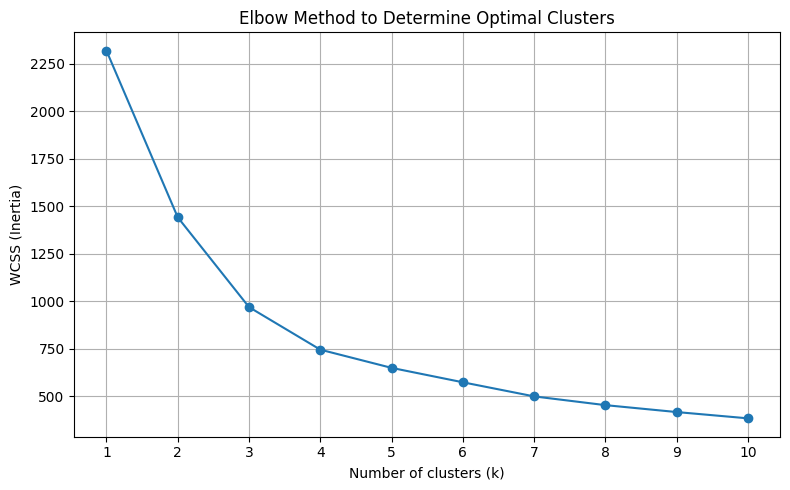

In [5]:
wcss = []  # Within-cluster sum of squares

# Try cluster sizes from 1 to 10
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method to Determine Optimal Clusters')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(range(1, 11))
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
# Step 5: KMeans Clustering (choose 4 clusters)
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Segment']=kmeans.fit_predict(rfm_scaled)
# Step 6: Print basic segment summary
print(rfm.groupby('Segment')[['Recency', 'Frequency', 'Monetary']].mean().round(1))

         Recency  Frequency  Monetary
Segment                              
0           59.7        5.6    2473.8
1           93.9        2.7    1193.7
2          433.3        2.0     762.1
3          106.9        5.9    6367.8
